## 미니 프로젝트 : OCR 활용 서비스

최근 무인으로 운영하는 매장의 수가 급격히 늘어나고 있다. 그에 따라, 청소년들의 비행 사례가 증가하고 있다. 이러한 문제점을 OCR을 이용한 신분증 검사 서비스로 해결할 수 있을 것이다.  


In [1]:
import os
import pytesseract
from PIL import Image
import cv2
from pytesseract import Output
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import keras_ocr

## 1. 테이터셋 준비

데이터셋은 주민등록증 견본과 운전면허증 견본을 사용한다.

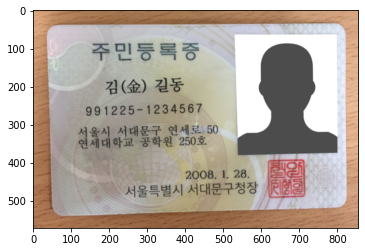

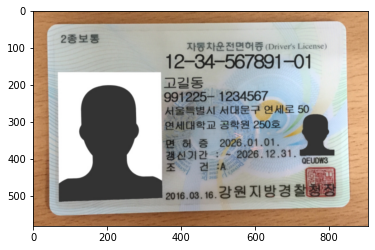

In [2]:
img_id_path = 'EP18_data/ID.png'
img_driver_path = 'EP18_data/driver.png'

img_bgr = cv2.imread(img_id_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

img_bgr = cv2.imread(img_driver_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. Google Cloud Vision API 사용

#### 구글의 파이썬 API 인터페이스 모듈 설치
```
$ pip install --upgrade google-api-python-client
$ pip install google-cloud-vision
```


In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/absolute-origin-326401-7163b8bd9bae.json'

# 위에서 정의한 OCR API 이용 함수를 호출
detect_text(img_id_path)

Texts:

"주민등록증
김 (쇼) 길동
991225-1234567
서울시 서대문구 연세로 50
연세대학교 공학원 250호
2008. 1. 28.
서울특별시 서대문구청장 R
"

"주민등록증"

"김"

"("

"쇼"

")"

"길동"

"991225-1234567"

"서울시"

"서대문구"

"연세"

"로"

"50"

"연세대"

"학교"

"공학원"

"250"

"호"

"2008."

"1."

"28."

"서울"

"특별시"

"서대문구"

"청장"

"R"
bounds: (603,445),(643,444),(644,486),(604,487)


In [5]:
detect_text(img_driver_path)

Texts:

"2종보통
자동차운전면허종 (Driver's License)
12-34-567891-01
고길동
991225- 1234567
서울특별시 서대문구 연세로 50
연세대학교 공학원 250호
면허증 2026.01.01.
갱신기간: ~
조
2026.12.31.
건 :A
QEUDW3
Driver's
asu
2016.03.16. 강원 지 방경 찰청장
"

"2"

"종"

"보통"

"자동차"

"운전"

"면허"

"종"

"("

"Driver's"

"License"

")"

"12-34-567891-01"

"고길동"

"991225-"

"1234567"

"서울"

"특별시"

"서대문구"

"연세"

"로"

"50"

"연세대"

"학교"

"공학원"

"250"

"호"

"면허증"

"2026.01.01"

"."

"갱신"

"기간"

":"

"~"

"조"

"2026.12.31."

"건"

":"

"A"

"QEUDW3"

"Driver's"

"asu"

"2016.03.16"

"."

"강원"

"지"

"방경"

"찰"

"청장"
bounds: (741,462),(809,459),(811,498),(743,501)


위와 같이 OCR 과정이 잘 되는 것을 확인 할 수 있다.

----
## 3. Tesseract

In [6]:
def crop_word_regions_kor(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"kor_{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [7]:
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        
        import cv2
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        print(recognized_data['text'])
    print("Done")

In [8]:
output_dir_id = 'EP18_data/output_id'
cropped_image_id_path_list = crop_word_regions_kor(img_id_path, output_dir_id)

EP18_data/output_id/kor_0000.png
EP18_data/output_id/kor_0001.png
EP18_data/output_id/kor_0002.png
EP18_data/output_id/kor_0003.png
EP18_data/output_id/kor_0004.png
EP18_data/output_id/kor_0005.png
EP18_data/output_id/kor_0006.png
EP18_data/output_id/kor_0007.png
EP18_data/output_id/kor_0008.png
EP18_data/output_id/kor_0009.png
EP18_data/output_id/kor_0010.png
EP18_data/output_id/kor_0011.png
EP18_data/output_id/kor_0012.png
EP18_data/output_id/kor_0013.png
EP18_data/output_id/kor_0014.png
EP18_data/output_id/kor_0015.png
EP18_data/output_id/kor_0016.png
EP18_data/output_id/kor_0017.png
EP18_data/output_id/kor_0018.png
EP18_data/output_id/kor_0019.png
EP18_data/output_id/kor_0020.png
EP18_data/output_id/kor_0021.png
EP18_data/output_id/kor_0022.png
EP18_data/output_id/kor_0023.png
EP18_data/output_id/kor_0024.png
EP18_data/output_id/kor_0025.png
EP18_data/output_id/kor_0026.png
EP18_data/output_id/kor_0027.png
EP18_data/output_id/kor_0028.png
EP18_data/output_id/kor_0029.png
EP18_data/

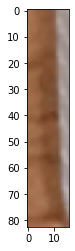

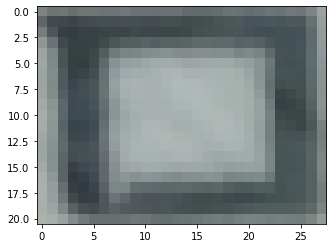

1 ㅣ



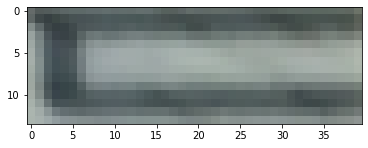

~



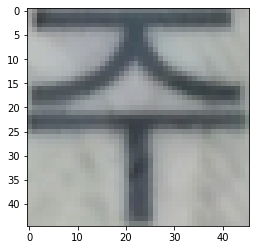

-는



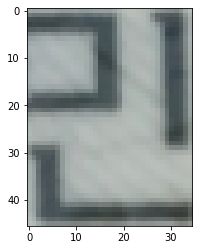

그 |



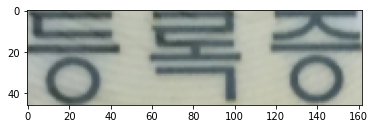

승독승



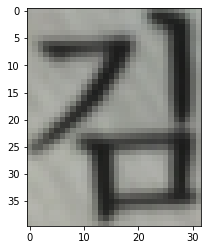

김



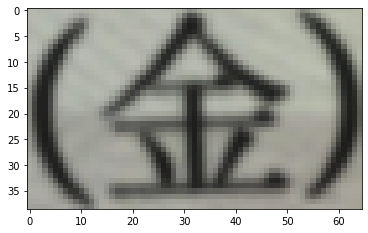

(<)



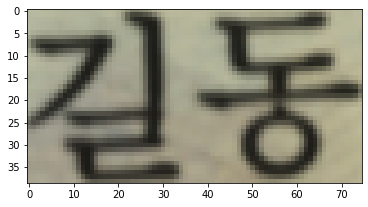

길동



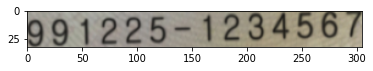

001225-123456/



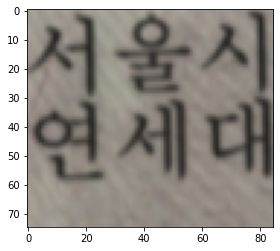

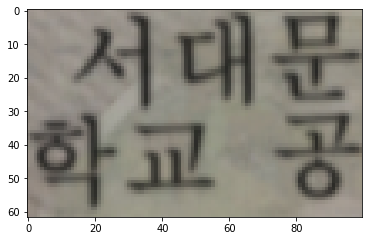

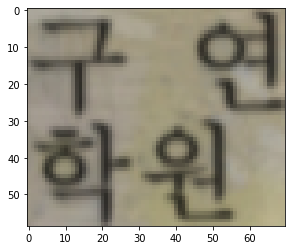

드어



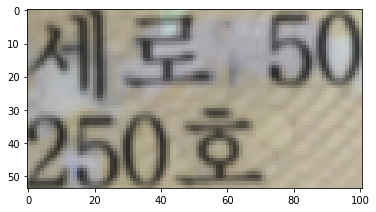

80



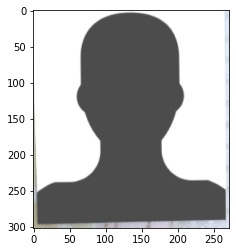

으



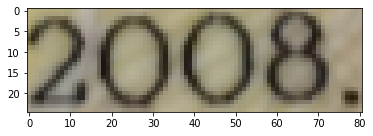

20008.



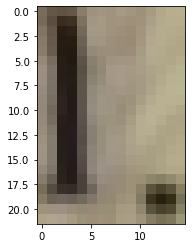

|.



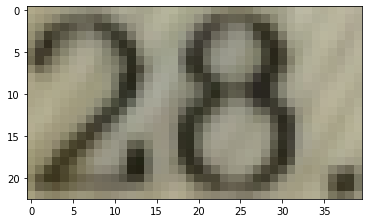

26



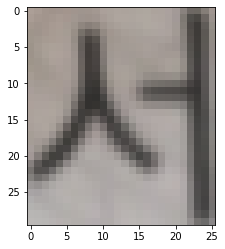

서



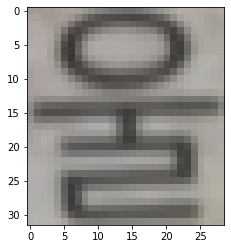

울



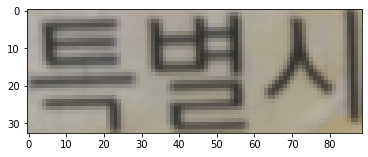

트별시



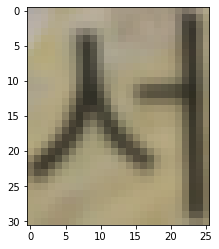

서



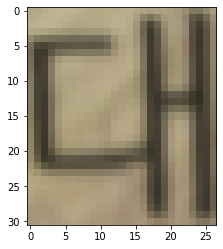

대



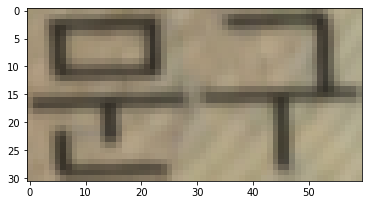

문구



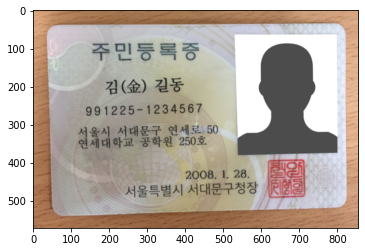

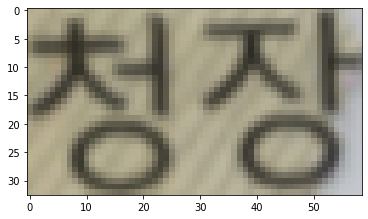

청장



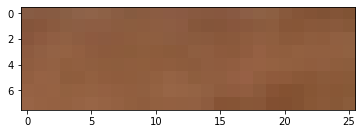

그



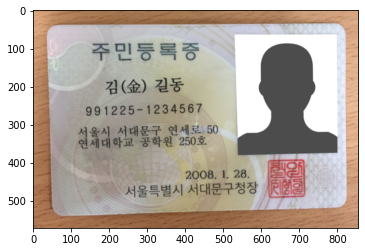

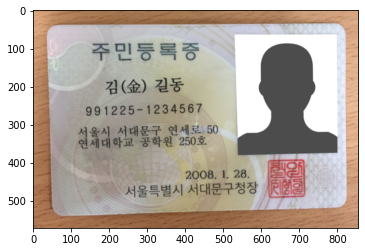

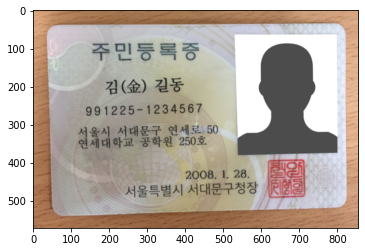

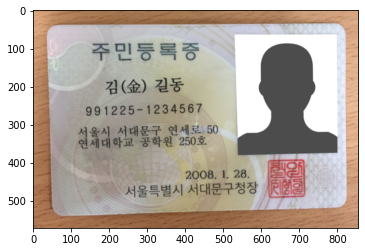

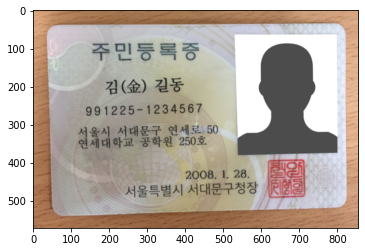

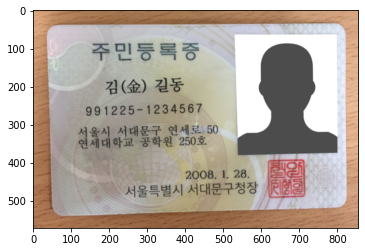

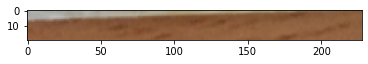

가 에 개 으르 이 개셔재재배 한 아거어“



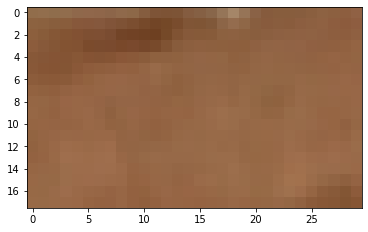

「부



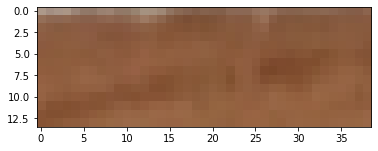

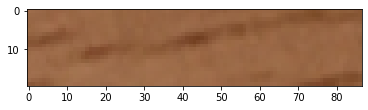

버스



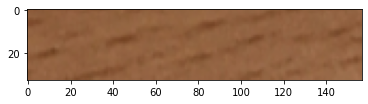

사사구

Done


In [10]:
recognize_images_kor(cropped_image_id_path_list)

In [11]:
output_dir_driver = 'EP18_data/output_driver'
cropped_image_driver_path_list = crop_word_regions_kor(img_driver_path, output_dir_driver)

EP18_data/output_driver/kor_0000.png
EP18_data/output_driver/kor_0001.png
EP18_data/output_driver/kor_0002.png
EP18_data/output_driver/kor_0003.png
EP18_data/output_driver/kor_0004.png
EP18_data/output_driver/kor_0005.png
EP18_data/output_driver/kor_0006.png
EP18_data/output_driver/kor_0007.png
EP18_data/output_driver/kor_0008.png
EP18_data/output_driver/kor_0009.png
EP18_data/output_driver/kor_0010.png
EP18_data/output_driver/kor_0011.png
EP18_data/output_driver/kor_0012.png


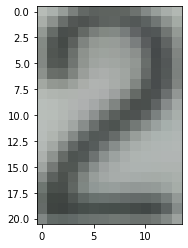

“》>



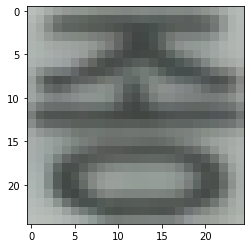

총



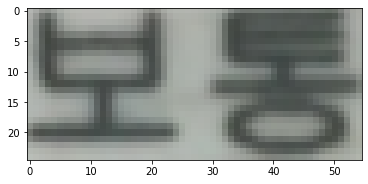

변통



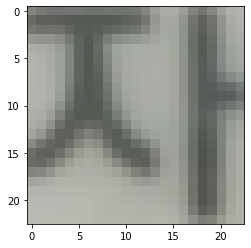

사



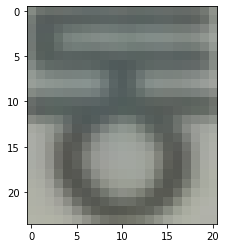

우



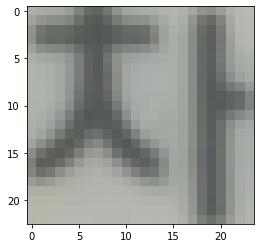

사



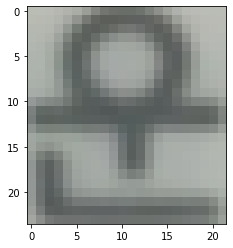

누



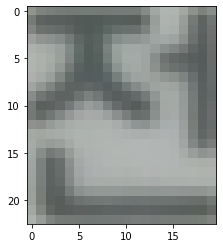

1



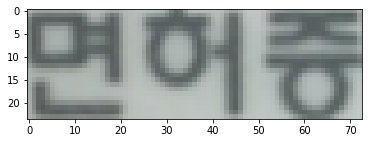

며허층



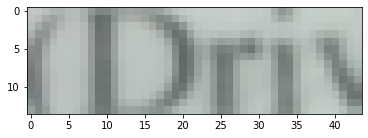

11 )러독



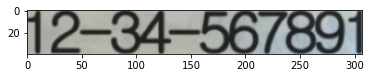

12-341-56> /91



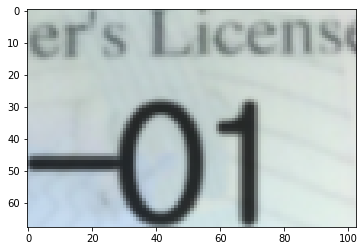

005



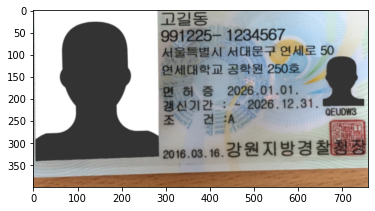

은 에으롱

Done


In [12]:
recognize_images_kor(cropped_image_driver_path_list)

Tesseract 를 사용했을시 글자 검출과 인식이 제대로 되지 않는 것을 확인 할 수 있다.